# Visualize Template

In [1]:
# Imports
from src.utils.helper import draw_shape
from src.utils.helper import load_config

import matplotlib.pyplot as plt
import torch
import numpy as np
import random
import json_tricks as json

In [ ]:
# Set up
device = torch.device('cuda:0')

In [11]:
# Functions
def showpoints(anchors, markersize = 2):
    #colors = ['#fc0cd2', '#54693f', '#ed28fd', '#3bfb0a', '#678916', '#f48f70', '#f447f1', '#3271ed', '#190b45', '#1a243c', '#9271b7', '#c25ec8', '#3c605a', '#e67c03', '#5e6674', '#4a9aa2', '#92910c', '#7b857f']
    colors = ["#%06x" % random.randint(0, 0xFFFFFF) for j in range(18)]

    i = 0
    for section in anchors:
        if section.shape[3] != 0:
            #print(section)
            for part in section.squeeze(0):
                #print(a)
                #print(part)
                for joint in part:
                    x = float(joint[0,0])
                    y = float(joint[1,0])
                    plt.plot(x, y, marker="o", color="r", markersize=markersize)
                i += 1

def draw_template(template, size, batch_size, device):
    """
    draw template consisting of limbs defined by gaussian heatmap
    Args:
        template: json file defining all parts
        size: int, image size (assumed quadratic), this should match the center coordinates defined in the json!
        device: torch.device, either cpu or gpu
    """
    heatmaps = []
    for v in template.values():
        center = torch.tensor(v['center']).to(device)
        sx = torch.tensor(v['sx']).to(device)
        sy = torch.tensor(v['sy']).to(device)
        angle = torch.tensor(v['angle']).to(device)
        heatmaps.append(draw_shape(center, sx, sy, angle, size))

    heatmaps = torch.cat(heatmaps, dim=1).repeat(batch_size, 1, 1, 1)

    return heatmaps

def load_anchor_points(anchor_points, device, batch_size):
    """
    load anchor points from json file
    change this according to your definitions
    Args:
        anchor_points: json file containing anchor points per part in column, row format similar to open-cv
        device: torch.device, either cpu or gpu
    """
    
    # assumes three anchor points for core, two (parent+child) for all others except hands and feet and head
    # change this accordingly for different template definitions!
    double = []
    single = []
    #print("helper.py anchor_points items: ", anchor_points.items())
    for k, v in anchor_points.items():
        if k in ['left hand', 'right hand', 'left foot', 'right foot', 'head']:
            single.append(v)
        elif k == 'core':
            triple = [v]
        else:
            double.append(v)

    return torch.tensor(triple).to(device).float().unsqueeze(-1).unsqueeze(0).repeat(batch_size, 1, 1, 1, 1), \
           torch.tensor(single).to(device).float().unsqueeze(-1).unsqueeze(0).repeat(batch_size, 1, 1, 1, 1), \
           torch.tensor(double).to(device).float().unsqueeze(-1).unsqueeze(0).repeat(batch_size, 1, 1, 1, 1)

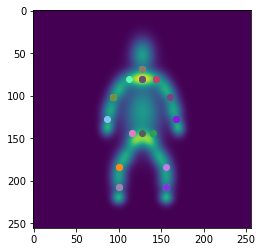

In [363]:
template_path = 'template.json'
anchor_points_path = 'anchor_points.json'
img_size = 256

# Open template
with open(template_path, 'r') as file:
    template_json = json.load(file)
    
with open(anchor_points_path, 'r') as file:
    anchor_points_json = json.load(file)

# Process jsons
template = draw_template(template_json, size=img_size, batch_size=1,
                                      device=device)
core, single, double = load_anchor_points(anchor_points_json, device, 1)
template_nums = template.squeeze(0).cpu().detach().numpy()
templates_sum = np.sum(template_nums, 0)

# Show heatmap
plt.imshow(templates_sum)
showpoints([core, double, single])
plt.show()